# Task 2 Clustering
!!! COMMENTS ON THE RESULTS WILL MOSTLY BE ADDED IN THE FINAL REPORT !!!

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans


In [2]:
#TODO: mettere i dataset ottenuti alla fine di Preparation
# We load the updated datasets
df_incidents = pd.read_csv('../dataset_preparation/incidents_prepared.csv', sep=',', index_col=0)

df_incidents.info()


<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 2015-05-02 to 2015-05-05
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   state                      161550 non-null  object 
 1   city_or_county             161550 non-null  object 
 2   address                    149848 non-null  object 
 3   latitude                   161550 non-null  float64
 4   longitude                  161550 non-null  float64
 5   congressional_district     161550 non-null  float64
 6   avg_age_participants       161550 non-null  float64
 7   incident_characteristics1  161550 non-null  object 
 8   year                       161550 non-null  float64
 9   age_group                  161550 non-null  object 
 10  povertyPercentage          161550 non-null  float64
 11  population                 161550 non-null  int64  
 12  party                      161550 non-null  object 
 13  candidatevotes       

## Selecting useful features for clustering
Now, we can select the most useful features for clustering. The selection is based on the correlation matrix, seen in the data preparation.
From the original dataset, we selected only the feature `avg_age_participants`.
We then use the features and indicators defined by us: `severity`, `severity_minor`, `killed_by_district`, `injured_by_district`, `female_ratio`, `povertyPercentage`, `arrested_ratio`, `unharmed_ratio`.

In [3]:
df_incidents.columns

Index(['state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants',
       'incident_characteristics1', 'year', 'age_group', 'povertyPercentage',
       'population', 'party', 'candidatevotes', 'severity', 'severity_cat',
       'severity_minor', 'year_month', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left', 'dfm_district_killed', 'dfm_district_injured',
       'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen',
       'dfm_district_females', 'voters_over_population'],
      dtype='object')

In [76]:
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']


In [5]:
# drop the columns that we don't need
df_incidents_clustering = df_incidents[cols_for_clustering]
df_incidents_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 2015-05-02 to 2015-05-05
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   avg_age_participants  161550 non-null  float64
 1   povertyPercentage     161550 non-null  float64
 2   severity              161550 non-null  float64
 3   severity_minor        161550 non-null  float64
 4   killed_by_district    161550 non-null  float64
 5   injured_by_district   161550 non-null  float64
 6   arrested_ratio        161550 non-null  float64
 7   unharmed_ratio        161550 non-null  float64
 8   right_or_left         161550 non-null  float64
dtypes: float64(9)
memory usage: 12.3+ MB


In [6]:
#entropy of each feature
from scipy.stats import entropy
for col in df_incidents_clustering.columns:
    print(col, entropy(df_incidents_clustering[col].value_counts(normalize=True)))

avg_age_participants 3.7726645408807515
povertyPercentage 4.18758888580303
severity 1.795126453848965
severity_minor 0.6260837228952216
killed_by_district 1.4039374353167249
injured_by_district 2.454894647628055
arrested_ratio 1.1864229069442342
unharmed_ratio 1.0220789597622542
right_or_left 6.495060360654568


In [7]:
#drop rows with nan
df_incidents_clustering = df_incidents_clustering.dropna()

## Scaling and PCA

In [8]:
scaler = StandardScaler()
df_incidents_scaled = scaler.fit_transform(df_incidents_clustering)
df_incidents_scaled = pd.DataFrame(df_incidents_scaled, columns=df_incidents_clustering.columns)
df_incidents_scaled.describe()



avg_age_participants  povertyPercentage      severity  severity_minor  \
count          1.615500e+05       1.615500e+05  1.615500e+05    1.615500e+05   
mean          -1.843761e-16      -2.075990e-16  1.600975e-16    2.199142e-17   
std            1.000003e+00       1.000003e+00  1.000003e+00    1.000003e+00   
min           -2.419643e+00      -2.617057e+00 -1.086602e+00   -3.248521e-01   
25%           -7.315237e-01      -6.516270e-01 -1.086602e+00   -3.248521e-01   
50%           -2.492038e-01      -1.056741e-01  1.059600e-01   -3.248521e-01   
75%            4.742761e-01       5.494693e-01  3.047203e-01   -3.248521e-01   
max            5.297475e+00       3.352027e+00  1.696042e+00    6.710766e+00   

       killed_by_district  injured_by_district  arrested_ratio  \
count        1.615500e+05         1.615500e+05    1.615500e+05   
mean         5.629803e-18        -5.629803e-18   -1.104849e-16   
std          1.000003e+00         1.000003e+00    1.000003e+00   
min         -4.436121e-01        -4.939728e-01   -7.317171e-01   
25%         -4.436121e-01        -4.939728e-01   -7.317171e-01   
50%         -4.436121e-01        -4.939728e-01   -7.317171e-01   
75%         -6.380239e-02         3.729213e-02    5.023855e-01   
max          4.114105e+00         4.287412e+00    1.736488e+00   

       unharmed_ratio  right_or_left  
count    1.615500e+05   1.615500e+05  
mean     1.238557e-16   3.856415e-16  
std      1.000003e+00   1.000003e+00  
min     -5.689729e-01  -2.083602e+00  
25%     -5.689729e-01  -8.098118e-01  
50%     -5.689729e-01  -1.053906e-01  
75%      6.680416e-01   7.901994e-01  
max      2.523563e+00   2.630336e+00

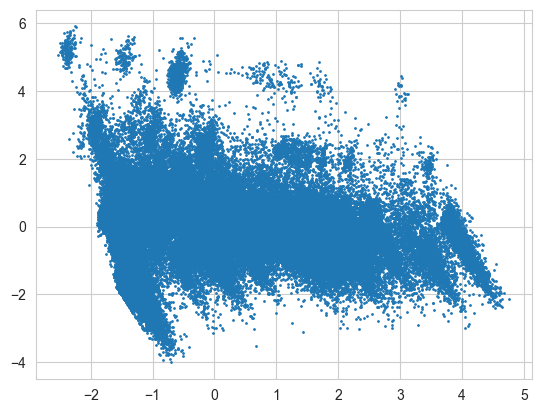

In [9]:
# pca in order to reduce the dimensionality of the dataset
pca = PCA(n_components=2)
df_incidents_pca = pca.fit_transform(df_incidents_scaled)
# plot the results
plt.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], s=1)



## K-means

### Selecting the number of clusters with the elbow method

In order to select the k number of clusters, we can use the elbow method: we run k-means for different values of k, and by plotting the SSE, we can see the elbow point, which is the optimal number of clusters.

In [10]:
# elbow method to find the optimal number of clusters
kmeans=[]

SSE = []
for i in range(1, 11):
    kmeans.append( KMeans(n_clusters=i, random_state=0, n_init=1).fit(df_incidents_scaled) )
    SSE.append(kmeans[i-1].inertia_)



([<matplotlib.axis.XTick at 0x1494ac13580>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

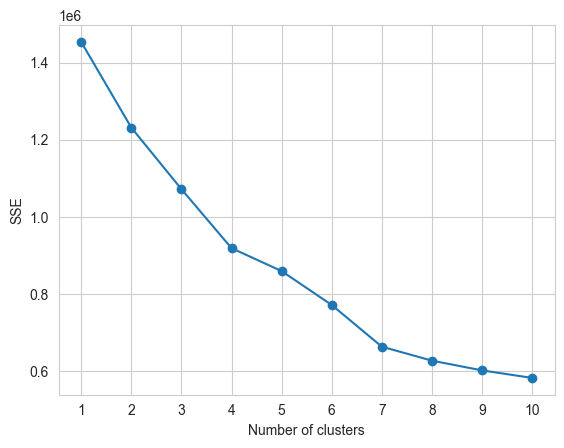

In [11]:
plt.plot( range(1,11),SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))

In [66]:
# #plot characteristics of each cluster
# for i in range(1,20):
#     labels = kmeans[i].labels_
#     df_incidents['cluster'] = labels
#     sns.countplot(data=df_incidents, x='cluster', hue='incident_characteristics1')
#     plt.show()

In [19]:
#we choose 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_incidents_clustering)
df_incidents['cluster_kmeans'] = kmeans.labels_
df_incidents['cluster_kmeans'].value_counts()
df_incidents_clustering['cluster'] = kmeans.labels_


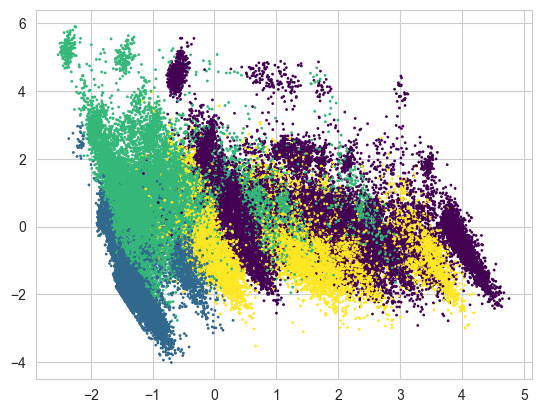

In [20]:
plt.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], c=df_incidents_clustering['cluster'], s=1, cmap='viridis')

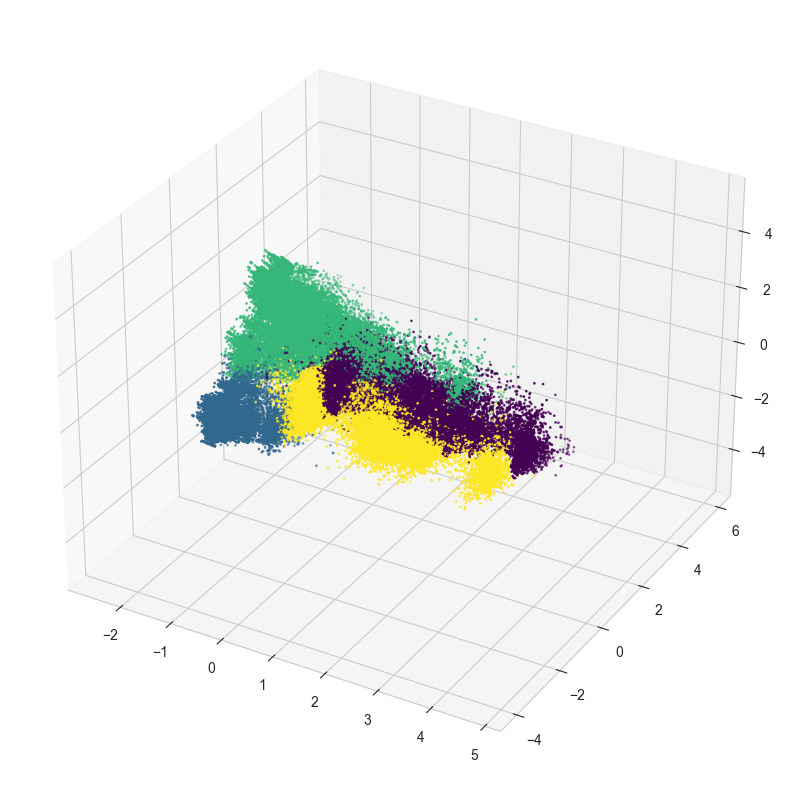

In [21]:
#plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca = pca.fit_transform(df_incidents_scaled)
ax.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], df_incidents_pca[:,2], c=df_incidents_clustering['cluster'], s=1, cmap='viridis')

<Axes: xlabel='cluster_kmeans', ylabel='count'>

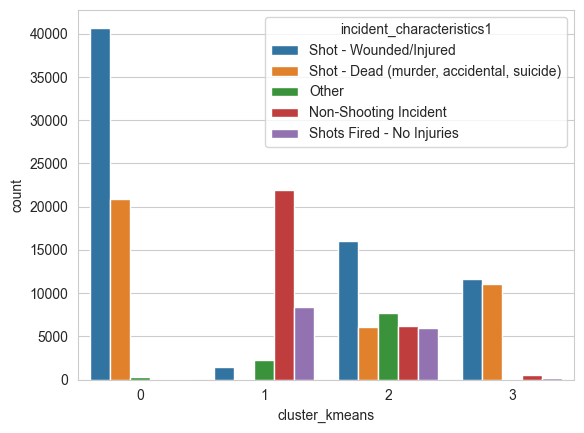

In [23]:
sns.countplot(data=df_incidents, x='cluster_kmeans', hue='incident_characteristics1')


We notice that 3 of the 4 clusters seem to have captured three different types of incidents, while the fourth cluster is a mix of the other three. We also notice how the characteristics of `shots fires - no injuries` and `non shooting accident` may be very similar, because the majority of them is in the same cluster.

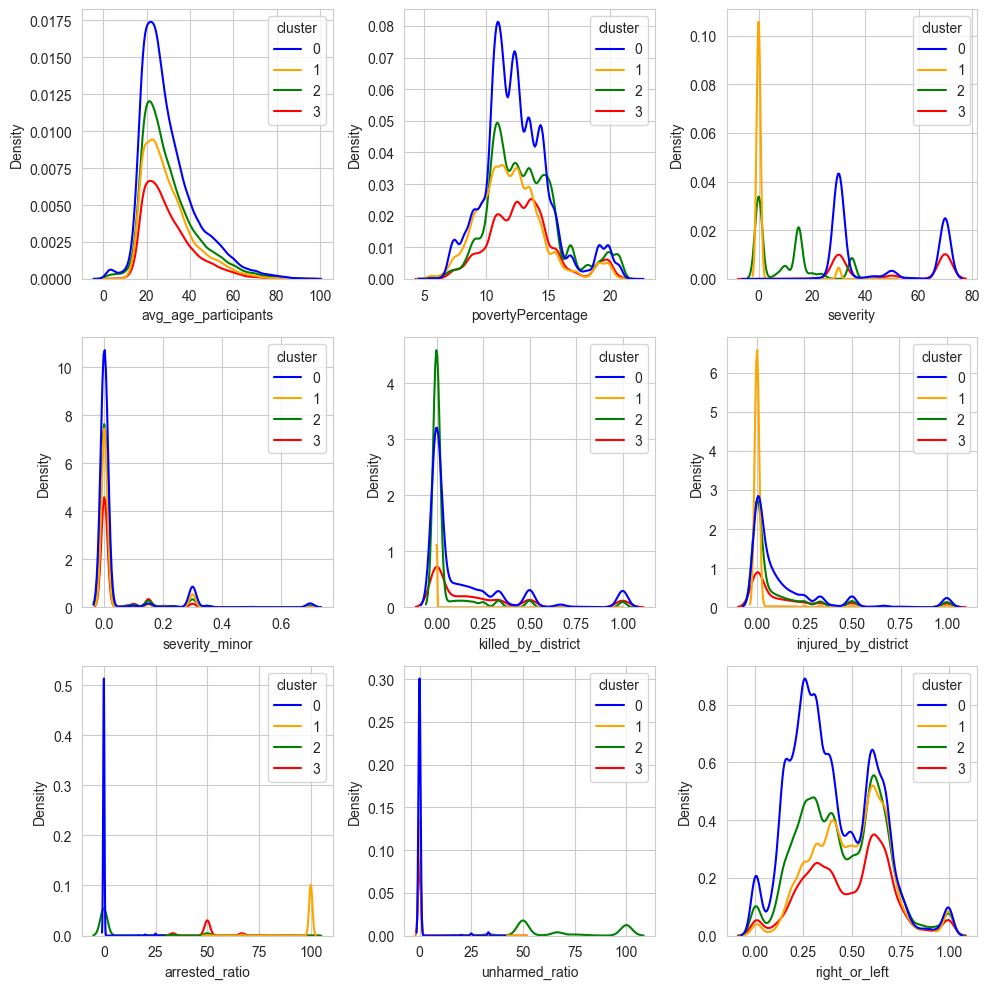

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])

plt.tight_layout()
plt.show()

### Second try

In [55]:
cols_to_keep = ['avg_age_participants', 'povertyPercentage',
       'severity', 'severity_minor', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [56]:
df_incidents_clustering2 = df_incidents[cols_to_keep]


In [57]:
#pca
scaler = StandardScaler()
df_incidents_scaled2 = scaler.fit_transform(df_incidents_clustering2)
df_incidents_scaled2 = pd.DataFrame(df_incidents_scaled2, columns=df_incidents_clustering2.columns)

df_incidents_pca2 = pca.fit_transform(df_incidents_scaled2)

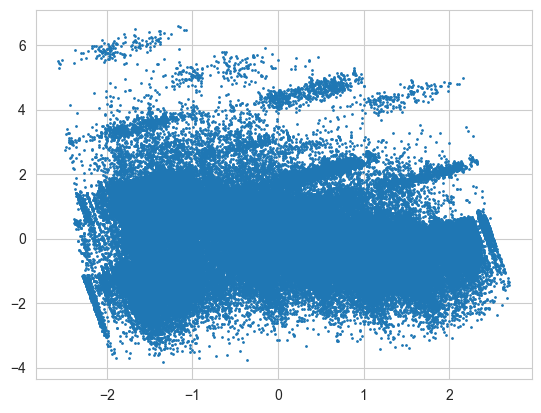

In [58]:
plt.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], s=1)

In [60]:
# elbow method to find the optimal number of clusters
kmeans=[]
SSE = []
for i in range(1, 11):
    kmeans.append( KMeans(n_clusters=i, random_state=0, n_init=1).fit(df_incidents_scaled2) )
    SSE.append(kmeans[i-1].inertia_)

([<matplotlib.axis.XTick at 0x149136d31c0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

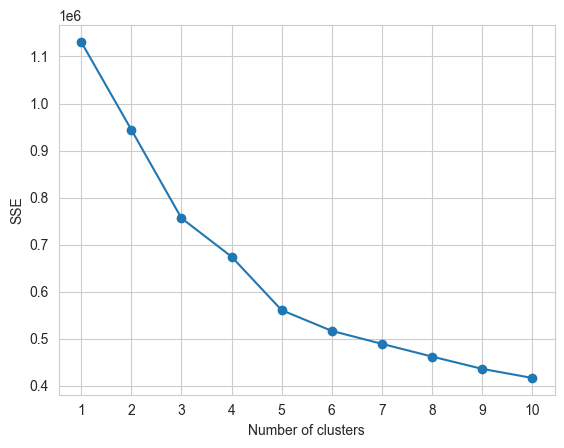

In [61]:
plt.plot( range(1,11),SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))

In [ ]:
#we choose 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(df_incidents_scaled2)
df_incidents['cluster_kmeans2'] = kmeans.labels_
df_incidents['cluster_kmeans2'].value_counts()
df_incidents_clustering2['cluster'] = kmeans.labels_

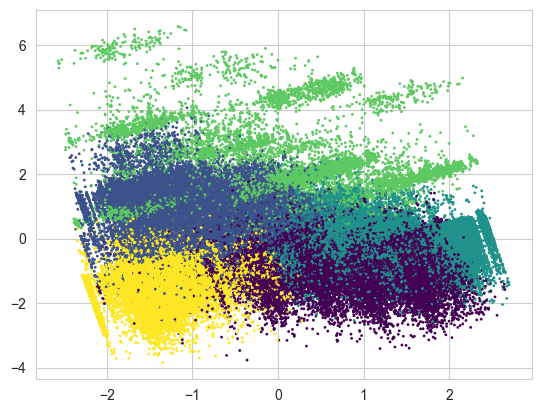

In [63]:
#plot 2d
plt.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')

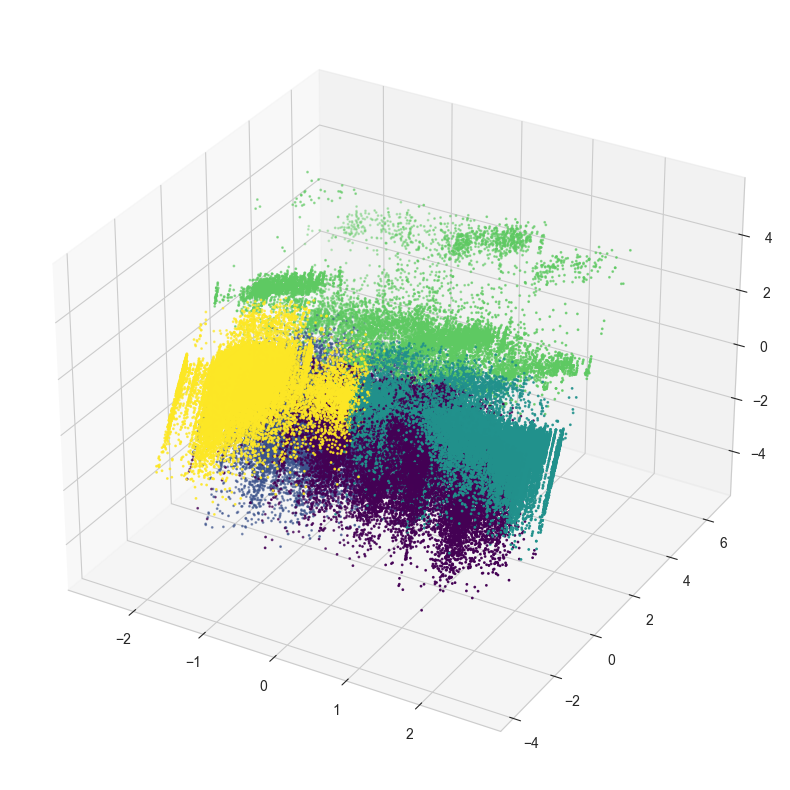

In [64]:
#plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca2 = pca.fit_transform(df_incidents_scaled2)
ax.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], df_incidents_pca2[:,2], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')


<Axes: xlabel='cluster_kmeans2', ylabel='count'>

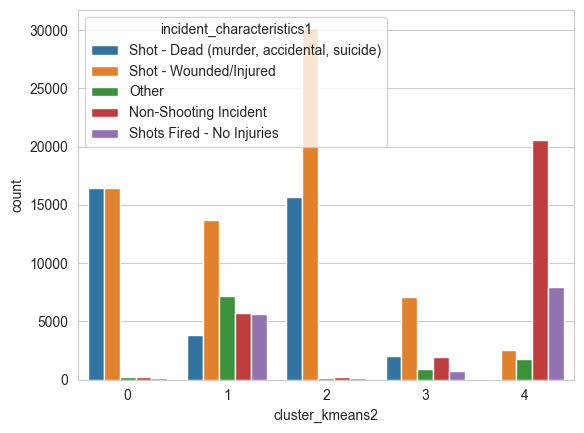

In [65]:
sns.countplot(data=df_incidents, x='cluster_kmeans2', hue='incident_characteristics1')

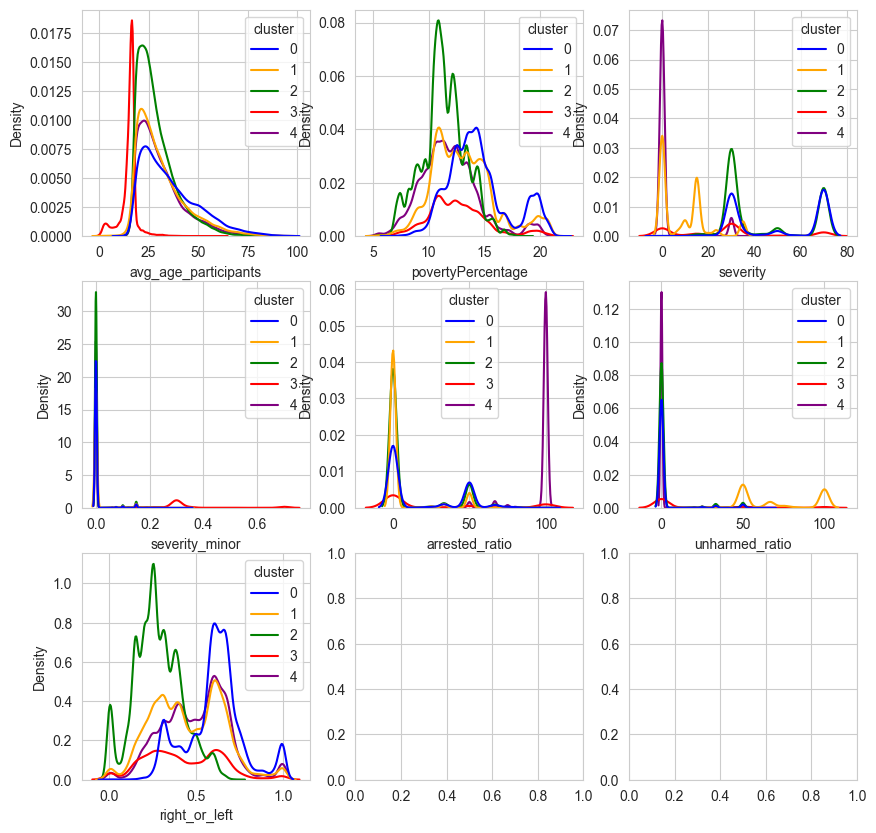

In [66]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering2.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering2, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple'])

In [ ]:
# k = 6
kmeans = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_incidents_scaled2)
df_incidents['cluster_kmeans2'] = kmeans.labels_
df_incidents['cluster_kmeans2'].value_counts()
df_incidents_clustering2['cluster'] = kmeans.labels_

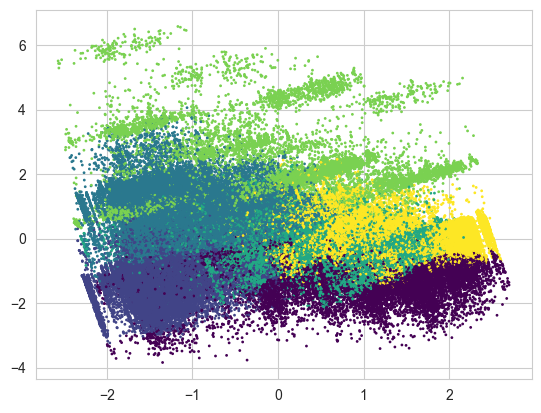

In [69]:
#plot 2d
plt.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')

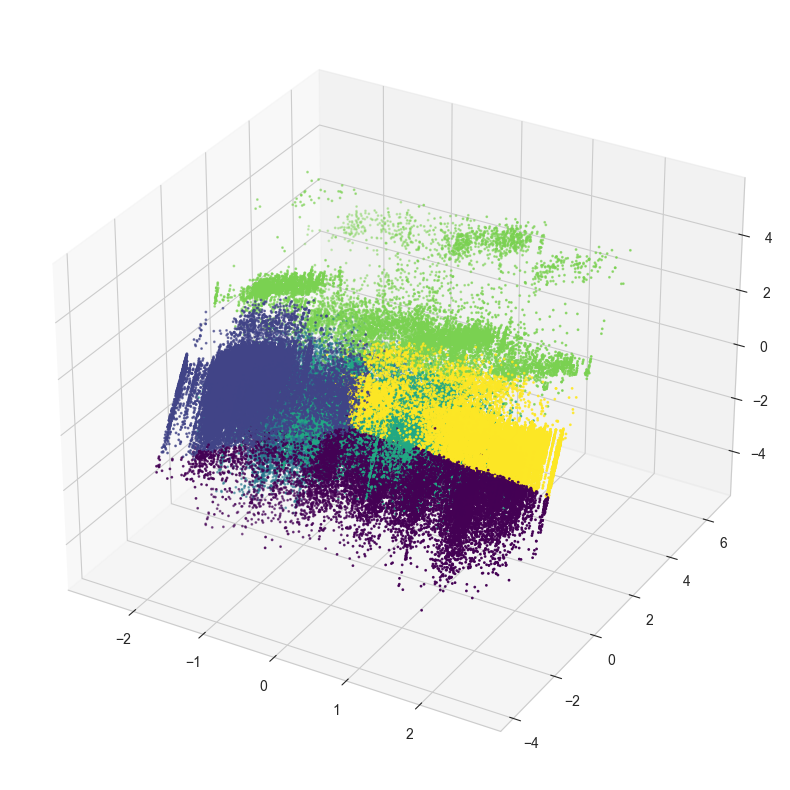

In [71]:
#plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca2 = pca.fit_transform(df_incidents_scaled2)
ax.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], df_incidents_pca2[:,2], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')

<Axes: xlabel='cluster_kmeans2', ylabel='count'>

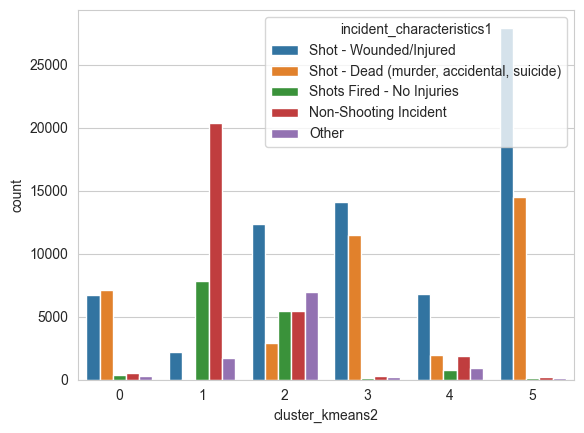

In [72]:
sns.countplot(data=df_incidents, x='cluster_kmeans2', hue='incident_characteristics1')

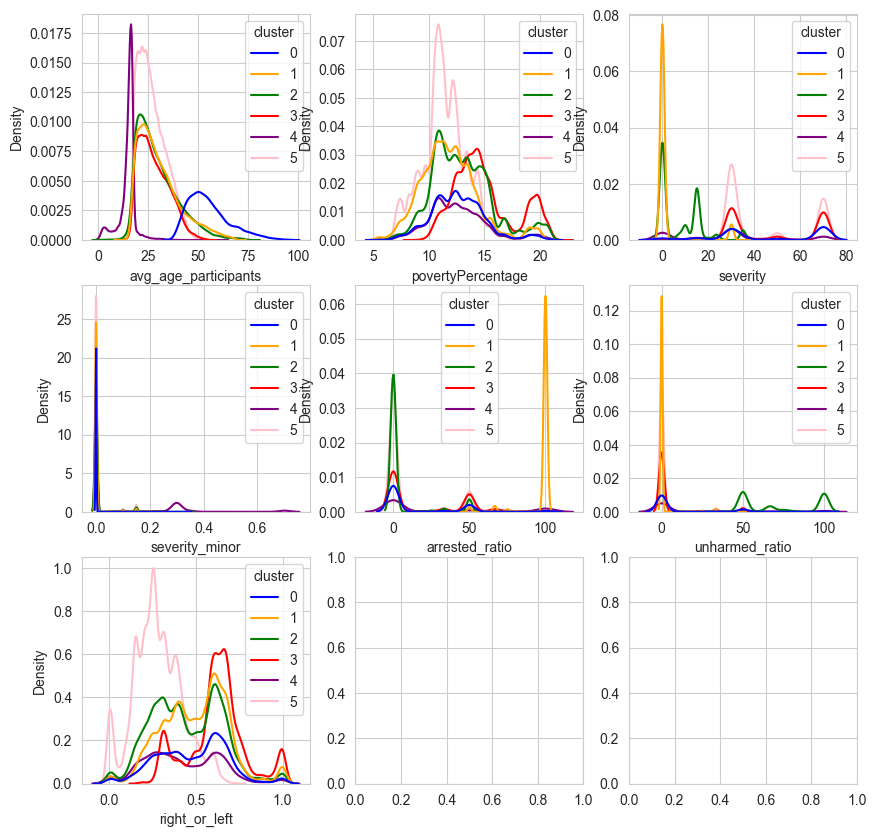

In [75]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering2.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering2, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])


## k- Means on single states
We take the most populated state: California, and the poorest and richest states: Mississippi and New Hampshire.

In [77]:
df_ca = df_incidents[df_incidents['state']=='california']
df_ms = df_incidents[df_incidents['state']=='mississippi']
df_nh = df_incidents[df_incidents['state']=='new hampshire']

In [79]:
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [80]:
df_ca_clustering = df_ca[cols_for_clustering]
df_ms_clustering = df_ms[cols_for_clustering]
df_nh_clustering = df_nh[cols_for_clustering]


In [81]:
#pca
scaler = StandardScaler()
df_ca_scaled = scaler.fit_transform(df_ca_clustering)
df_ca_scaled = pd.DataFrame(df_ca_scaled, columns=df_ca_clustering.columns)
df_ms_scaled = scaler.fit_transform(df_ms_clustering)
df_ms_scaled = pd.DataFrame(df_ms_scaled, columns=df_ms_clustering.columns)
df_nh_scaled = scaler.fit_transform(df_nh_clustering)
df_nh_scaled = pd.DataFrame(df_nh_scaled, columns=df_nh_clustering.columns)

In [82]:
#pca of the three states
pca = PCA(n_components=2)
df_ca_pca = pca.fit_transform(df_ca_scaled)
df_ms_pca = pca.fit_transform(df_ms_scaled)
df_nh_pca = pca.fit_transform(df_nh_scaled)

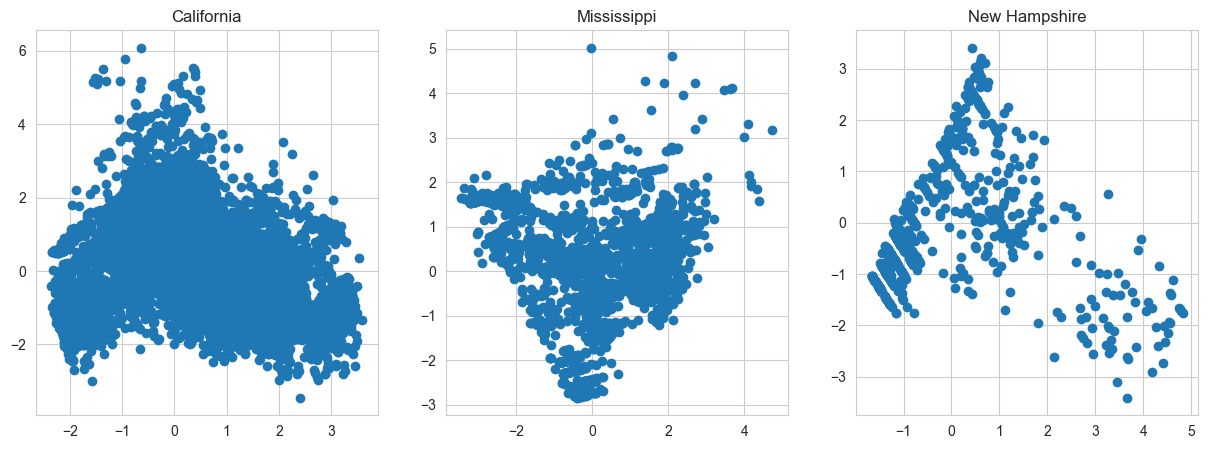

In [87]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(df_ca_pca[:,0], df_ca_pca[:,1])
ax[1].scatter(df_ms_pca[:,0], df_ms_pca[:,1])
ax[2].scatter(df_nh_pca[:,0], df_nh_pca[:,1])
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')

plt.show()


In [93]:
# elbow method to find the optimal number of clusters
kmeans_ca=[]
SSE_ca = []
for i in range(1, 11):
    kmeans_ca.append( KMeans(n_clusters=i, random_state=0, n_init=5).fit(df_ca_scaled) )
    SSE_ca.append(kmeans_ca[i-1].inertia_)

In [94]:

kmeans_ms=[]
SSE_ms = []
for i in range(1, 11):
    kmeans_ms.append( KMeans(n_clusters=i, random_state=0, n_init=5).fit(df_ms_scaled) )
    SSE_ms.append(kmeans_ms[i-1].inertia_)

In [95]:
kmeans_nh=[]
SSE_nh = []
for i in range(1, 11):
    kmeans_nh.append( KMeans(n_clusters=i, random_state=0, n_init=5).fit(df_nh_scaled) )
    SSE_nh.append(kmeans_nh[i-1].inertia_)


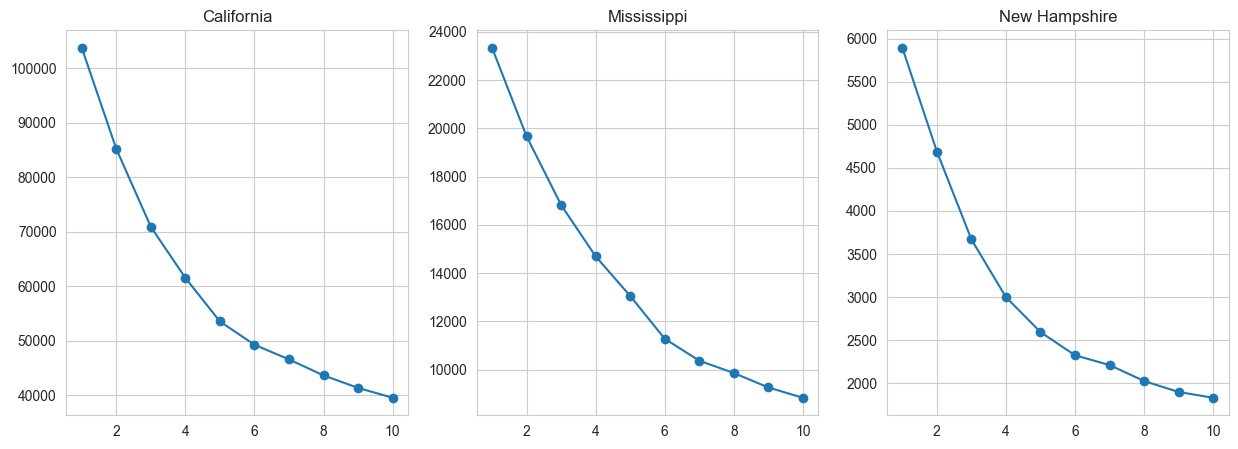

In [96]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot( range(1,11),SSE_ca, marker='o')
ax[1].plot( range(1,11),SSE_ms, marker='o')
ax[2].plot( range(1,11),SSE_nh, marker='o')
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')
plt.show()


In [0]:
#we choose 6 clusters for all the three states
kmeans_ca = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_ca_scaled)
df_ca['cluster_kmeans'] = kmeans_ca.labels_
df_ca['cluster_kmeans'].value_counts()
df_ca_clustering['cluster'] = kmeans_ca.labels_

In [ ]:

kmeans_ms = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_ms_scaled)
df_ms['cluster_kmeans'] = kmeans_ms.labels_
df_ms['cluster_kmeans'].value_counts()
df_ms_clustering['cluster'] = kmeans_ms.labels_

In [104]:

kmeans_nh = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_nh_scaled)
df_nh['cluster_kmeans'] = kmeans_nh.labels_
df_nh['cluster_kmeans'].value_counts()
df_nh_clustering['cluster'] = kmeans_nh.labels_


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\2427694601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nh['cluster_kmeans'] = kmeans_nh.labels_
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\2427694601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nh_clustering['cluster'] = kmeans_nh.labels_


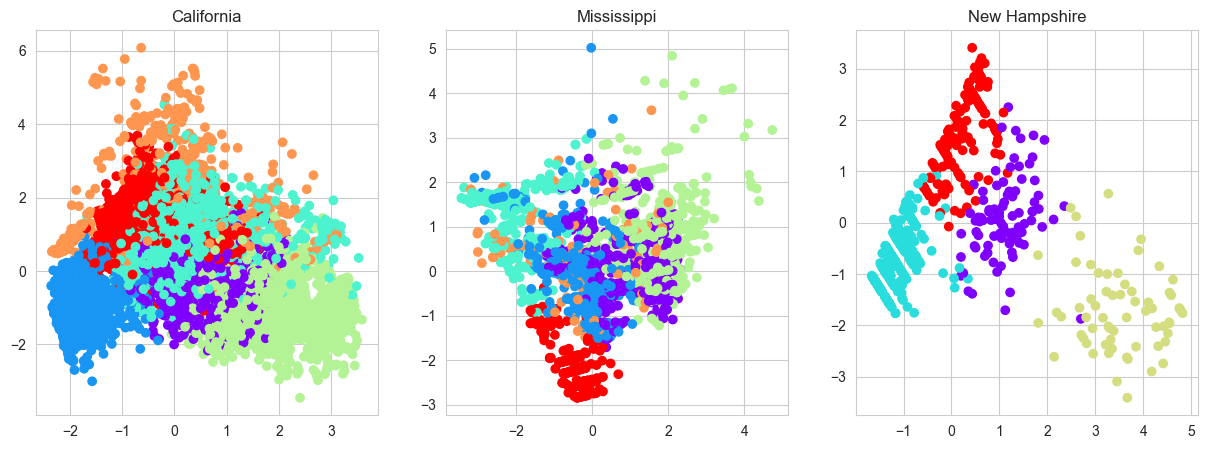

In [105]:
#plot 2d
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca_clustering['cluster'], cmap='rainbow')
ax[1].scatter(df_ms_pca[:,0], df_ms_pca[:,1], c=df_ms_clustering['cluster'], cmap='rainbow')
ax[2].scatter(df_nh_pca[:,0], df_nh_pca[:,1], c=df_nh_clustering['cluster'], cmap= 'rainbow')
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')
plt.show()


In [107]:
#plot 3d

pca= PCA(n_components=3)
df_ca_pca = pca.fit_transform(df_ca_scaled)
df_ms_pca = pca.fit_transform(df_ms_scaled)
df_nh_pca = pca.fit_transform(df_nh_scaled)

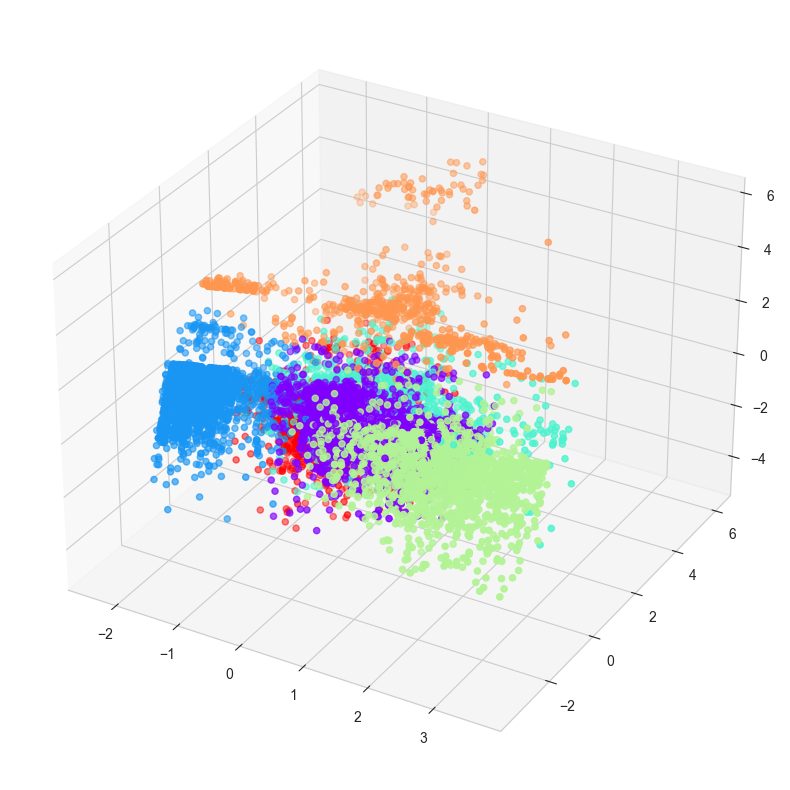

In [111]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_ca_pca[:,0], df_ca_pca[:,1], df_ca_pca[:,2], c=df_ca_clustering['cluster'], cmap='rainbow')

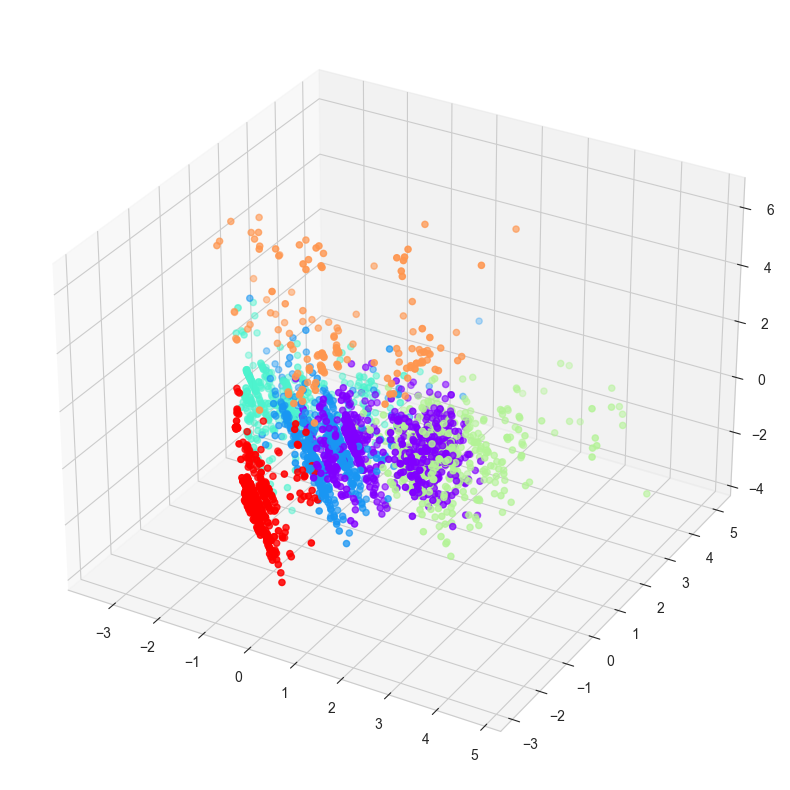

In [112]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_ms_pca[:,0], df_ms_pca[:,1], df_ms_pca[:,2], c=df_ms_clustering['cluster'],  cmap='rainbow')

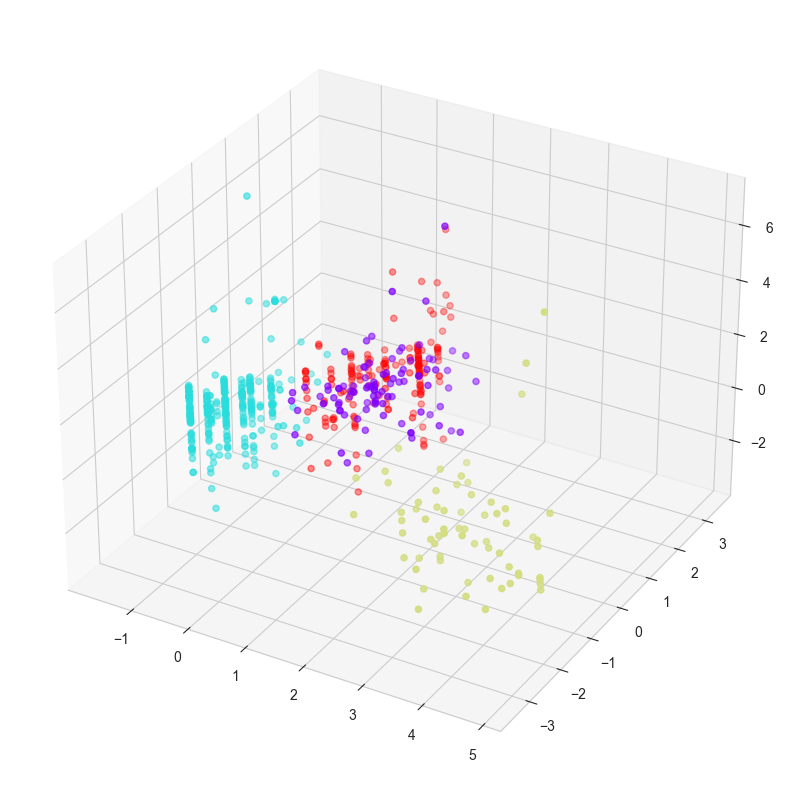

In [113]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_nh_pca[:,0], df_nh_pca[:,1], df_nh_pca[:,2], c=df_nh_clustering['cluster'],  cmap='rainbow')


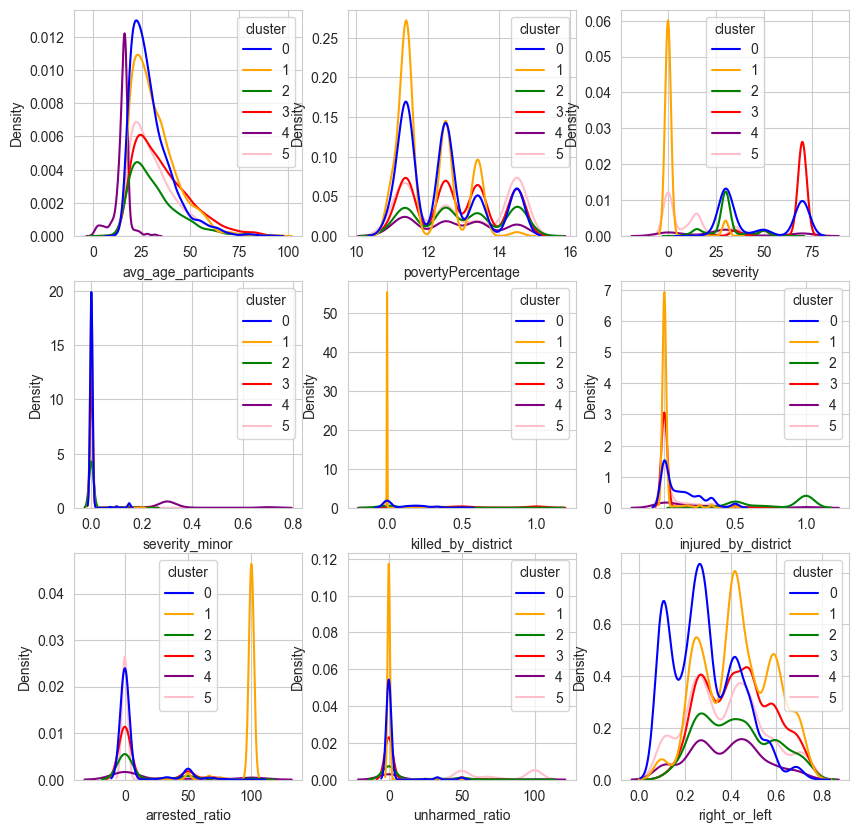

In [114]:
# kdes
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_ca_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_ca_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\1634919963.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_ms_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])


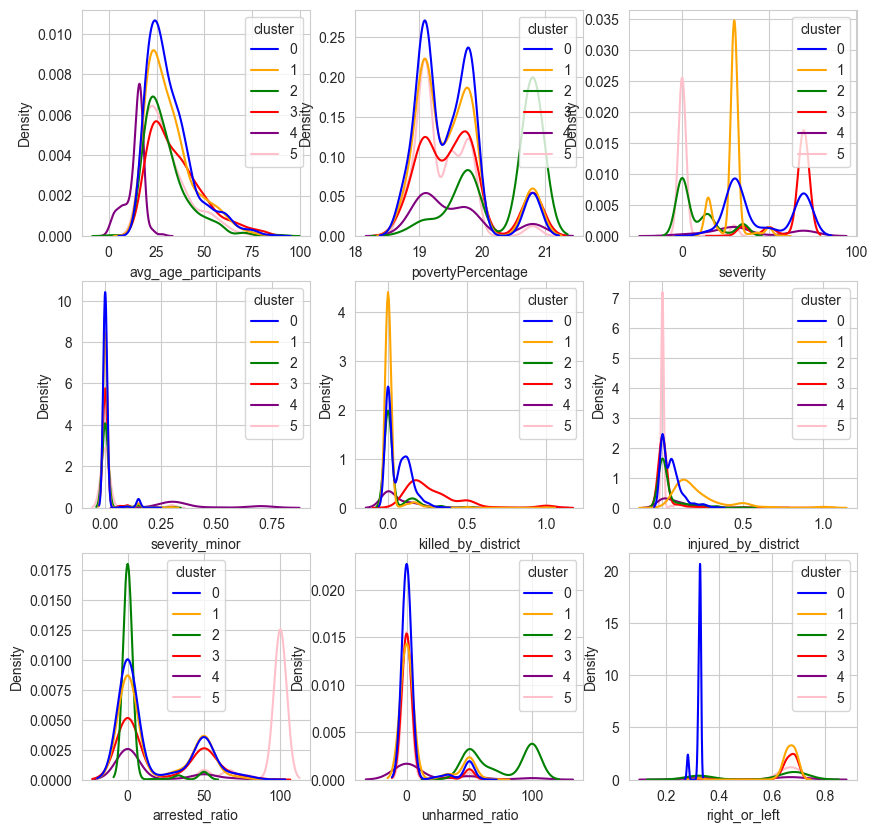

In [115]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_ms_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_ms_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\3425757771.py:3: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\3425757771.py:3: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\3425757771.py:3: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\3425757771.py:3: UserWarning: The palette list 

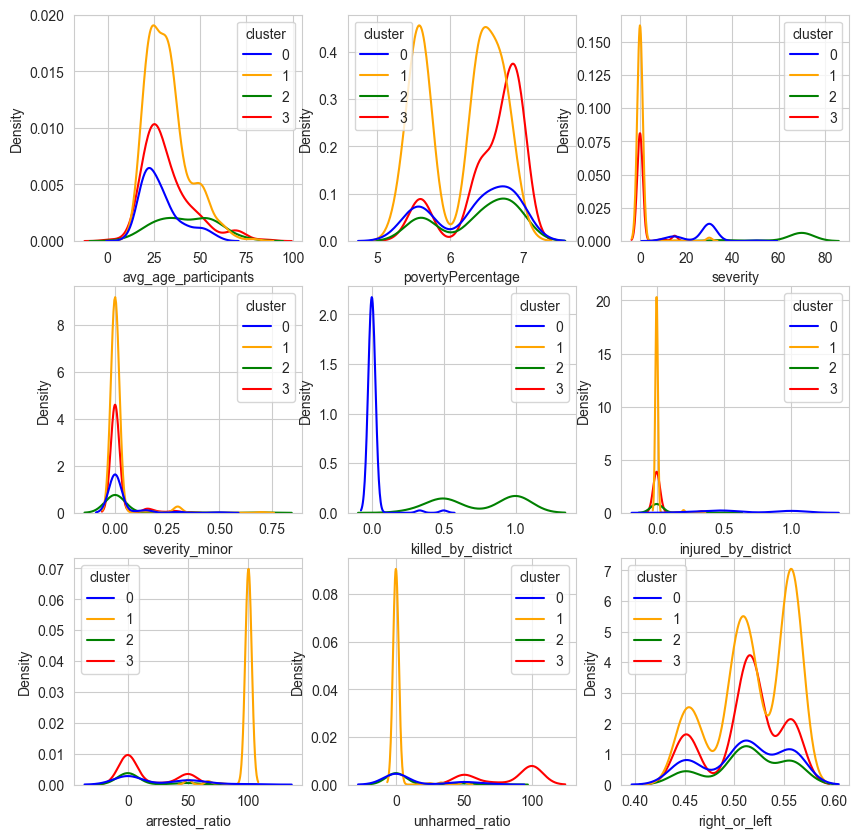

In [116]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_nh_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])

## DBSCAN

In [143]:
from sklearn.cluster import DBSCAN

In [133]:
#we choose the same features as before
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

df_incidents_clustering = df_incidents[cols_for_clustering]

['avg_age_participants',
 'severity',
 'severity_minor',
 'killed_by_district',
 'injured_by_district',
 'right_or_left']

In [138]:
df_ca = df_incidents[df_incidents['state']=='california']
df_ca_clustering = df_ca[cols_for_clustering]

In [139]:
df_ca_scaled = scaler.fit_transform(df_ca_clustering)

In [140]:
#pca
pca = PCA(n_components=2)
df_ca_pca = pca.fit_transform(df_ca_scaled)


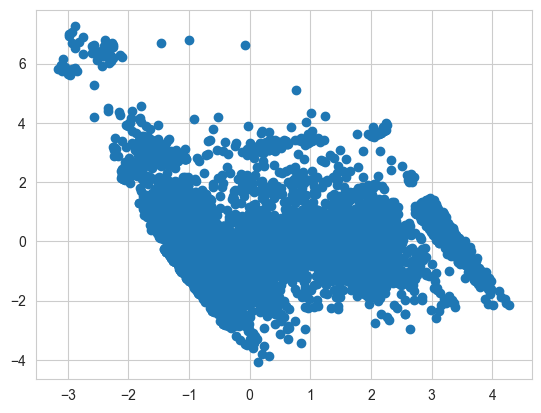

In [141]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1])

In [144]:
# dbscan


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\1402714151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_dbscan'] = dbscan.labels_


 1     6336
 0     2174
-1     1136
 2      506
 6      449
 7      338
 8       93
 10      86
 5       73
 12      40
 25      32
 29      21
 23      19
 18      17
 26      15
 3       15
 22      13
 19      13
 13      12
 30      11
 9       10
 4       10
 11       8
 21       8
 16       7
 34       7
 33       7
 14       7
 24       6
 20       6
 15       6
 17       5
 31       5
 28       5
 38       5
 32       5
 36       5
 35       5
 39       5
 37       4
 27       3
Name: cluster_dbscan, dtype: int64

### Selecting the k and epsilon plotting the k-distance graph

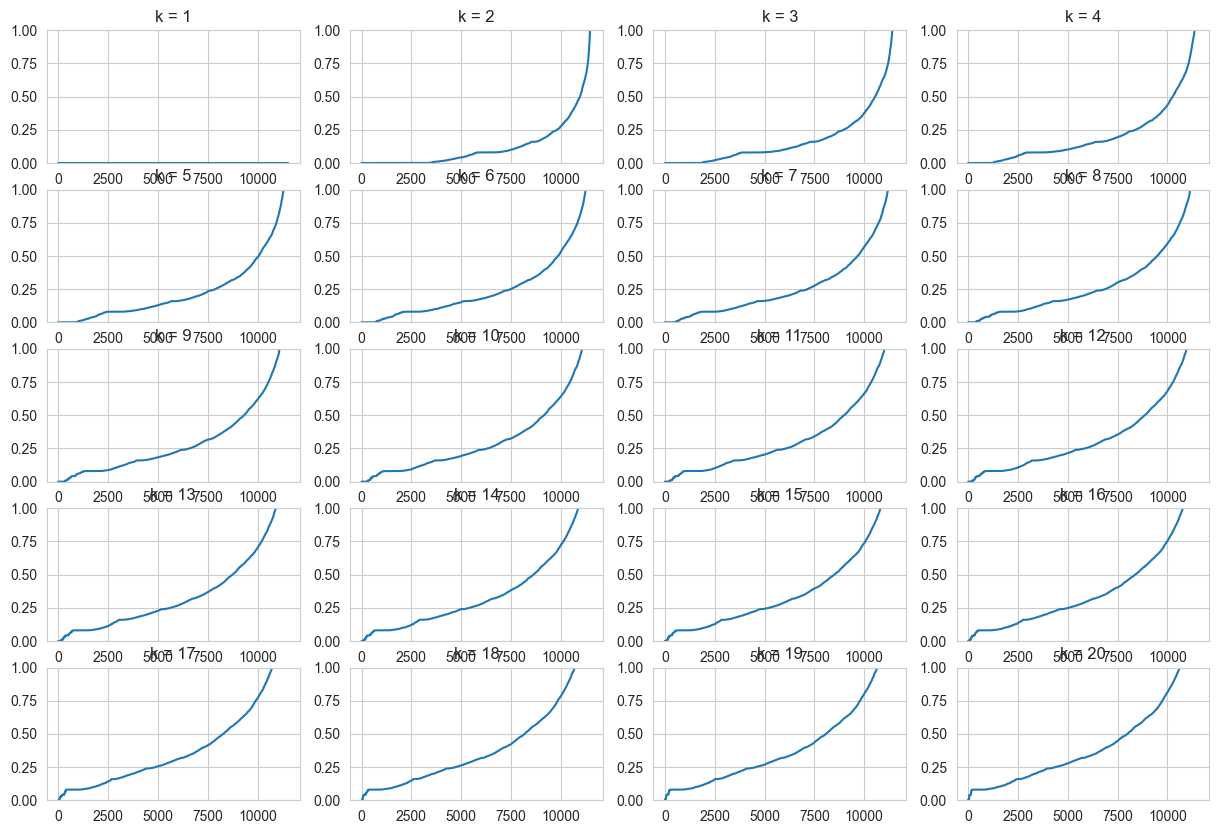

In [151]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_ca_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_ca_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])

In [154]:
dbscan= DBSCAN(eps=0.85, min_samples=5).fit(df_ca_scaled)
df_ca['cluster_dbscan'] = dbscan.labels_
df_ca['cluster_dbscan'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\891136902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_dbscan'] = dbscan.labels_


 0    11086
-1      235
 2       48
 1       45
 4       42
 3       26
 6       19
 9       10
 7        6
 5        6
 8        5
Name: cluster_dbscan, dtype: int64

In [158]:
df_fl = df_incidents[df_incidents['state']=='florida']
df_fl_clustering = df_fl[cols_for_clustering]

In [159]:
df_fl_scaled = scaler.fit_transform(df_fl_clustering)

In [160]:
#pca
pca = PCA(n_components=2)
df_fl_pca = pca.fit_transform(df_fl_scaled)


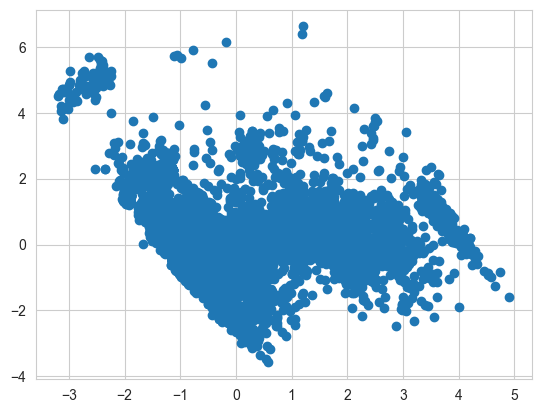

In [161]:
plt.scatter(df_fl_pca[:,0], df_fl_pca[:,1])

### Selecting the k and epsilon plotting the k-distance graph

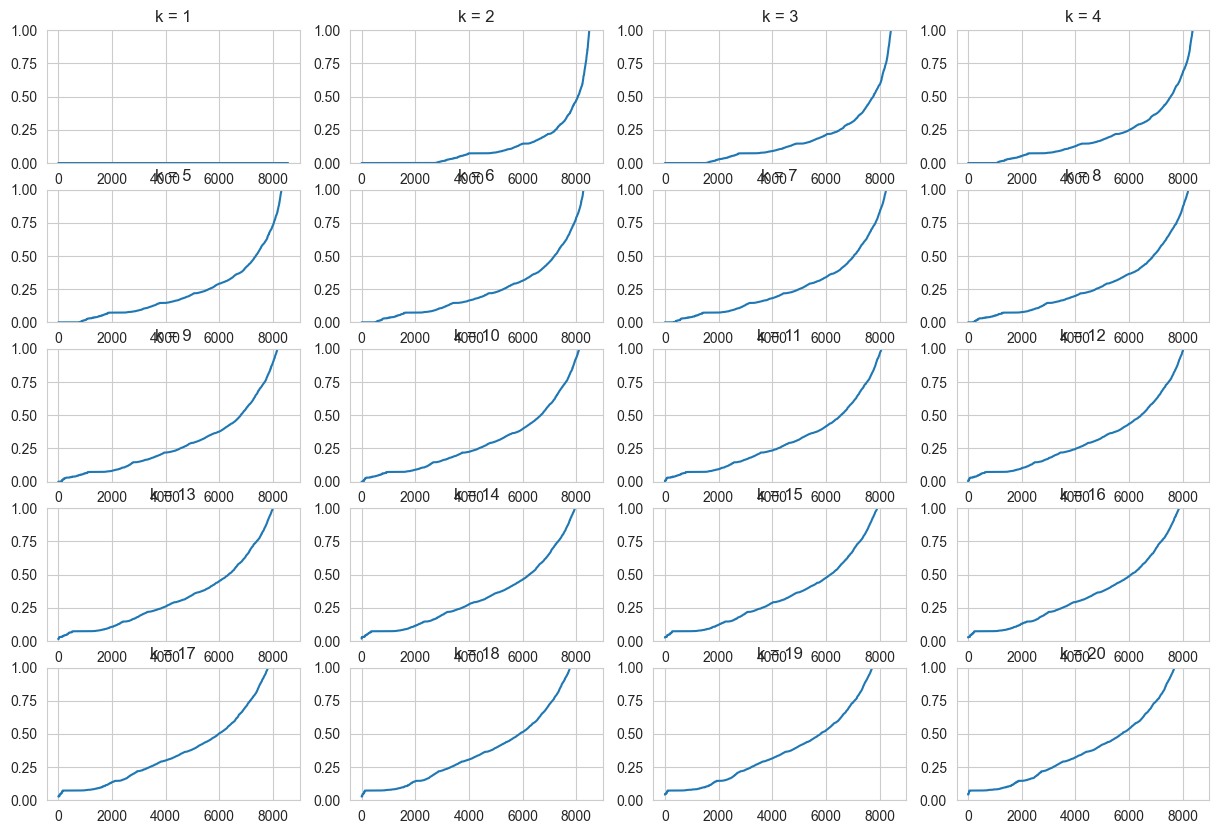

In [164]:
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_fl_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_fl_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])

In [174]:
dbscan= DBSCAN(eps=0.6, min_samples=10).fit(df_fl_scaled)
df_fl['cluster_dbscan'] = dbscan.labels_
df_fl['cluster_dbscan'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\2176782065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['cluster_dbscan'] = dbscan.labels_


 0     5298
 1     1065
-1      958
 6      386
 3      210
 2      190
 5      177
 13      38
 4       36
 8       28
 20      19
 12      17
 10      16
 7       15
 18      15
 17      15
 9       14
 11      14
 14      12
 21      11
 19      11
 16       9
 15       7
Name: cluster_dbscan, dtype: int64

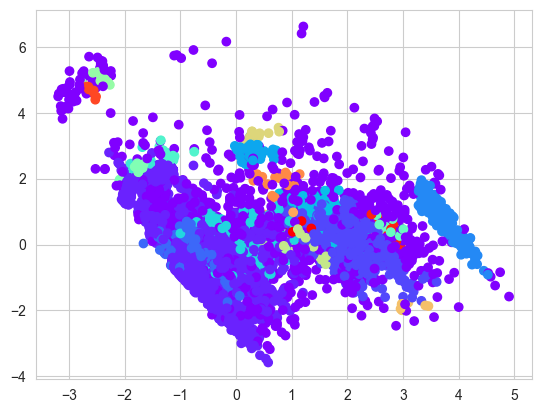

In [175]:
plt.scatter(df_fl_pca[:,0], df_fl_pca[:,1], c=df_fl['cluster_dbscan'], cmap='rainbow')

In [176]:
#plot 3d
pca= PCA(n_components=3)
df_fl_pca = pca.fit_transform(df_fl_scaled)

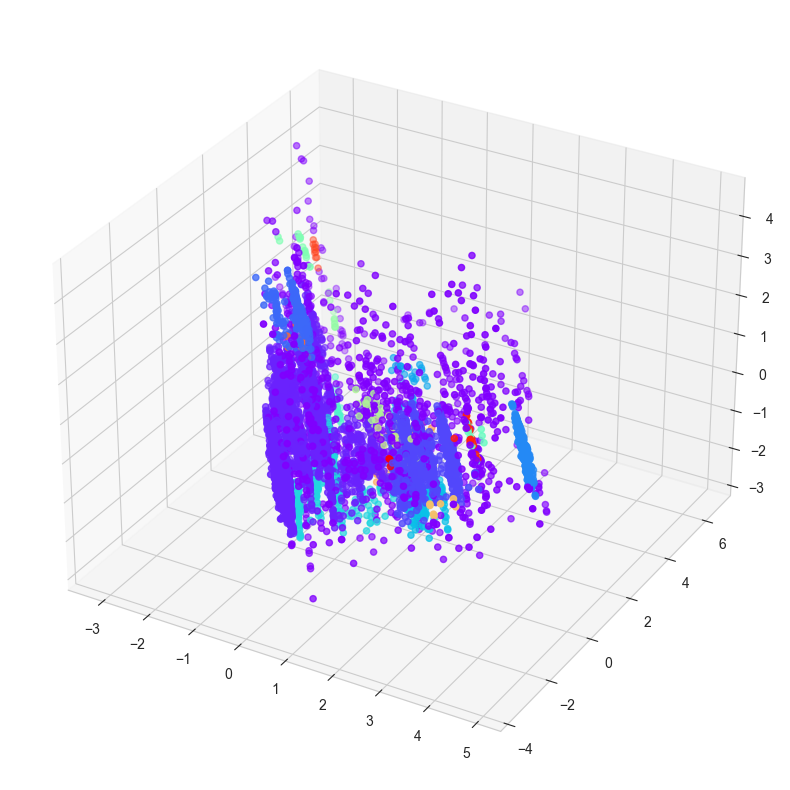

In [177]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_fl_pca[:,0], df_fl_pca[:,1], df_fl_pca[:,2], c=df_fl['cluster_dbscan'], cmap='rainbow')

## Hierarchical clustering
TODO

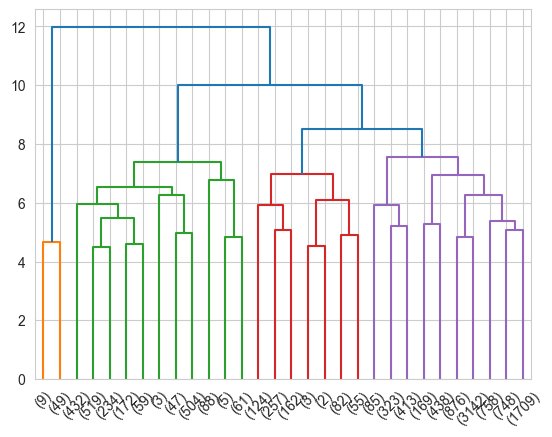

In [188]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

In [190]:
from sklearn.cluster import AgglomerativeClustering
aggcluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
aggcluster.fit_predict(df_ca_scaled)
df_ca['cluster_agg_comp'] = aggcluster.labels_
df_ca['cluster_agg_comp'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\493240204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_agg'] = aggcluster.labels_


0    8661
2    2124
1     685
3      58
Name: cluster_agg, dtype: int64

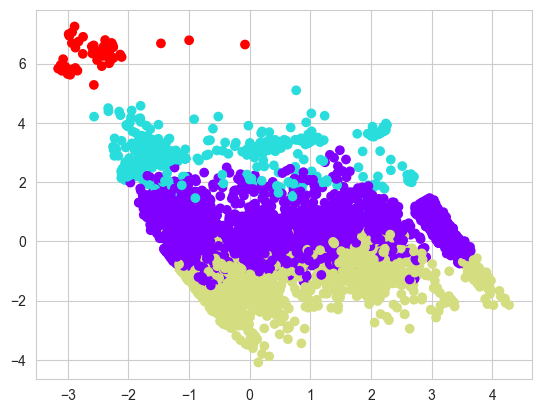

In [192]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_agg'], cmap='rainbow')

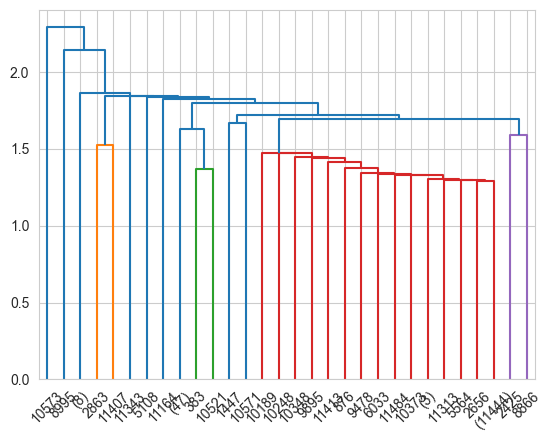

In [193]:
data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

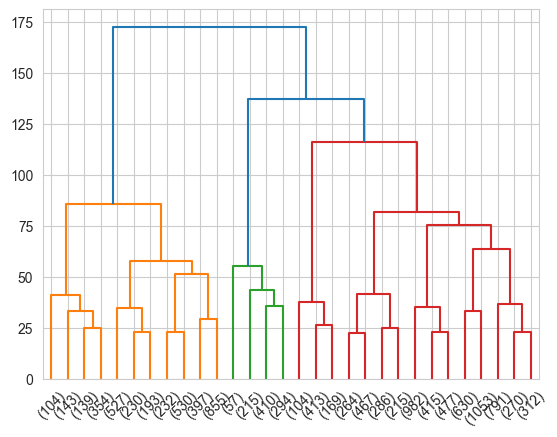

In [194]:
data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

from the dendrogram, we can see that the red cluster can be splitted in two clusters, so we can try to use 4 clusters.

In [195]:
aggcluster_ward = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
aggcluster_ward.fit_predict(df_ca_scaled)
df_ca['cluster_agg_ward'] = aggcluster_ward.labels_
df_ca['cluster_agg_ward'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_8416\3969782099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_agg_ward'] = aggcluster_ward.labels_


1    6162
0    3704
2     976
3     686
Name: cluster_agg_ward, dtype: int64

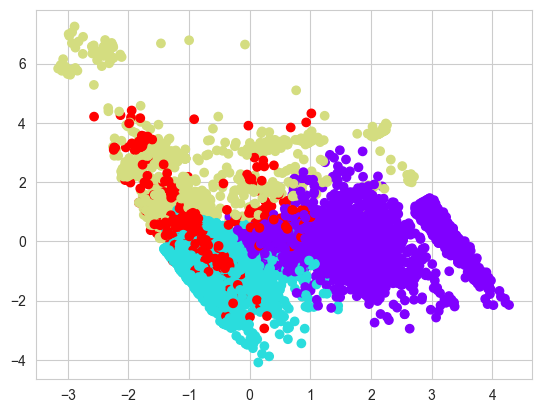

In [196]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_agg_ward'], cmap='rainbow')

In [ ]:
#todo ran kmeans on the clusters obtained with hierarchical clustering

## Cluster validation
TODO